## 問題１ (重回帰の練習)

今回説明した手法を使って、重回帰の練習をしましょう。まず自分で何らかのデータセットを用意します（webから回帰向きのデータを検索）。そして、そのデータの前処理、重回帰モデルの学習、モデルの改善、ベストなモデルの選択、テスト性能の評価までを一通り行い、得られた結果について考察を加えてください。LASSOだけではなく、Ridgeも試してみましょう。モデルの学習結果から、データに関する何らかの仮説が立てられたり洞察が得られるとベストです。

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.datasets import load_diabetes
from sklearn.linear_model import Ridge
import seaborn as sns

## 糖尿病データセット

In [2]:
# データをロードする
diabetes = load_diabetes()
print(diabetes.DESCR)

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

age： 年齢\
sex： 性別\
bmi： BMI（肥満度）\
bp： 平均血圧\
s1： TC（血液中の総コレステロール値）\
s2： LDL（低比重リポタンパク質、悪玉コレステロール）\
s3： HDL（高比重リポタンパク質、善玉コレステロール）\
s4： TCH（＝TC÷HDL＝総コレステロール値／善玉コレステロール）\
s5： LTG（血液中の中性脂肪値の対数）\
s6： GLU（血糖値）\

In [3]:
df = pd.DataFrame(diabetes.data, columns=("age", "sex", "bmi", "bp", "tc", "ldl", "hdl", "tch", "ltg", "glu"))
df['target'] = diabetes.target
df.head()

,age,sex,bmi,bp,tc,ldl,hdl,tch,ltg,glu,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,135.0


In [4]:
# 欠損値確認
df.isna().sum()

age       0
sex       0
bmi       0
bp        0
tc        0
ldl       0
hdl       0
tch       0
ltg       0
glu       0
target    0
dtype: int64

In [5]:
# 説明変数と目的変数を生成
X_all = df.loc[:,:"glu"]
y = df.loc[:,"target":]

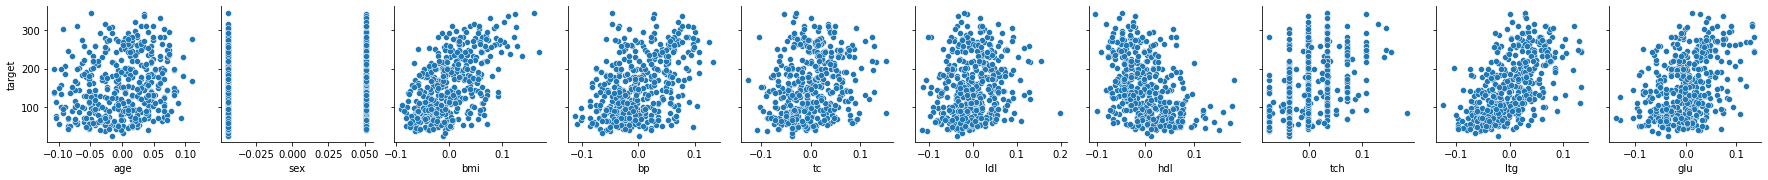

In [6]:
# 各属性と出力変数との間の相関具合も確認
sns.pairplot(data=pd.concat([X_all, y], axis=1),
             y_vars=['target'], 
             x_vars=["age", "sex", "bmi", "bp", "tc", "ldl", "hdl", "tch", "ltg", "glu"])

In [7]:
# "age", "sex", "tch"列はtargetと関係ないと思いますので、単純に削除します
X_drop = X_all.drop("age", axis=1)
X_drop = X_drop.drop("sex", axis=1)
X_drop = X_drop.drop("tch", axis=1)

In [8]:
X_drop.head()

,bmi,bp,tc,ldl,hdl,ltg,glu
0,0.061696,0.021872,-0.044223,-0.034821,-0.043401,0.019908,-0.017646
1,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.068330,-0.092204
2,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,0.002864,-0.025930
3,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.022692,-0.009362
4,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.031991,-0.046641


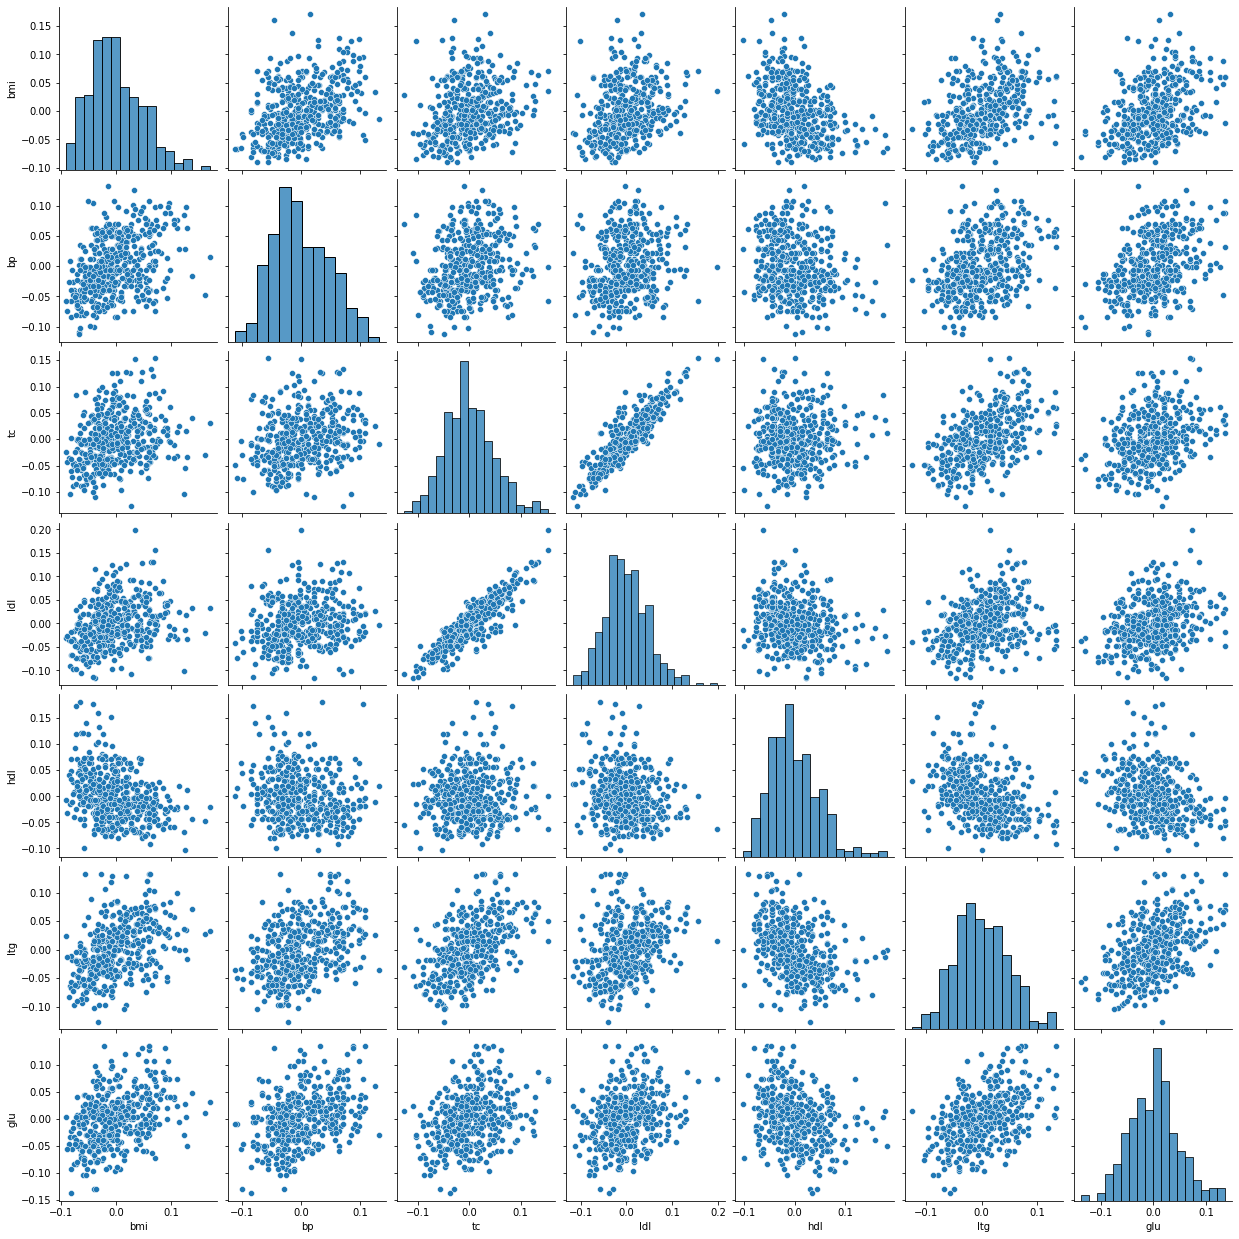

In [9]:
# 相関性を確認
sns.pairplot(X_drop)

In [10]:
# "tc", "ldl"は強い関係と見えているので、多重共線性かもしれません
X_drop = X_drop.drop("tc", axis=1)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_drop, y, test_size=0.3, random_state=666)

## LASSOでモデル構築

In [12]:
# パイルラインでモデルをインスタンスする
pipeLine_lasso = Pipeline([
    #('poly', PolynomialFeatures()),
    #('scaler', StandardScaler()),
    ('lasso', Lasso(max_iter=100000))])

In [13]:
# モデルで使用されたパラメータを設定する
parameter_lasso = {
    #"poly__degree":[1, 2, 3, 4, 5], 
    "lasso__alpha": [0.0001, 0.00015, 0.001, 0.0015, 0.01, 0.1, 1]
}

In [14]:
# GridSearchCVを使用する
model_lasso = GridSearchCV(pipeLine_lasso, param_grid=parameter_lasso)

In [15]:
model_lasso.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('lasso', Lasso(max_iter=100000))]),
             param_grid={'lasso__alpha': [0.0001, 0.00015, 0.001, 0.0015, 0.01,
                                          0.1, 1]})

In [16]:
model_lasso.score(X_test, y_test)

0.5581037579394963

In [17]:
# ベストスコア、ベストハイパラメータをディスプレー
print("best_score:", model_lasso.best_score_)
print("best_params:", model_lasso.best_params_)
print("best_estimator:", model_lasso.best_estimator_)

best_score: 0.44589342050561953
best_params: {'lasso__alpha': 0.1}
best_estimator: Pipeline(steps=[('lasso', Lasso(alpha=0.1, max_iter=100000))])


In [18]:
lasso_coef = model_lasso.best_estimator_.get_params()['lasso'].coef_
lasso_coef

array([ 563.99009766,  245.58841525,  -96.32256014, -187.19046213,
        503.47342917,    0.        ])

## Ridgeでモデル構築

In [19]:
# パイルラインでモデルをインスタンスする
pipeLine_ridge = Pipeline([
    #('poly', PolynomialFeatures()),
    #('scaler', StandardScaler()),
    ('ridge', Ridge())])

# モデルで使用されたパラメータを設定する
parameter_ridge = {
    #"poly__degree":[1, 2, 3, 4, 5], 
    #"poly__include_bias": [True, False],
    "ridge__alpha": [2**i for i in range(-10,1)]
}

# GridSearchCVを使用する
model_ridge = GridSearchCV(pipeLine_ridge, param_grid=parameter_ridge)

model_ridge.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('ridge', Ridge())]),
             param_grid={'ridge__alpha': [0.0009765625, 0.001953125, 0.00390625,
                                          0.0078125, 0.015625, 0.03125, 0.0625,
                                          0.125, 0.25, 0.5, 1]})

In [20]:
model_ridge.score(X_test, y_test)

0.5568429033081925

In [21]:
# ベストスコア、ベストハイパラメータをディスプレー
print("best_score:", model_ridge.best_score_)
print("best_params:", model_ridge.best_params_)
print("best_estimator:", model_ridge.best_estimator_)

best_score: 0.44502947733344345
best_params: {'ridge__alpha': 0.0625}
best_estimator: Pipeline(steps=[('ridge', Ridge(alpha=0.0625))])


In [22]:
ridge_coef = model_ridge.best_estimator_.get_params()['ridge'].coef_
ridge_coef

array([[ 541.76340492,  264.41474207, -138.17017208, -219.57843702,
         496.9324008 ,   38.084786  ]])

## 考査

In [23]:
attributes = ["bmi", "bp", "ldl", "hdl", "tch", "ltg", "glu"]

for a,c in zip(attributes, lasso_coef):
    # cの小数点以下４桁目までprintする
    print('coef of '+a,':', '{:.4f}'.format(c))

coef of bmi : 563.9901
coef of bp : 245.5884
coef of ldl : -96.3226
coef of hdl : -187.1905
coef of tch : 503.4734
coef of ltg : 0.0000


In [24]:
attributes = ["bmi", "bp", "ldl", "hdl", "tch", "ltg", "glu"]

for a,c in zip(attributes, ridge_coef[0]):
    # cの小数点以下４桁目までprintする
    print('coef of '+a,':', '{:.4f}'.format(c))

coef of bmi : 541.7634
coef of bp : 264.4147
coef of ldl : -138.1702
coef of hdl : -219.5784
coef of tch : 496.9324
coef of ltg : 38.0848


BMI（肥満度）とbp（平均血圧）とTCHは正で大きいので、値は高くと、糖尿病になる可能性は高いと思います。　　\
ldl（悪玉コレステロール）とhdl（善玉コレステロール）は負で大きいので、値は小さくと、糖尿病になる可能性は高いと思います。